In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

# Pre-processing section
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import math # for rmse

%matplotlib inline

In [297]:
# %matplotlib qt5

# Bank Marketing

**Abstract:** The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

*The data source: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing*

### Importing datasets

In [2]:
# [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. 
# Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 

bank_train = pd.read_csv("bank/bank-full.csv", low_memory = False, sep=';')
bank_test = pd.read_csv("bank/bank.csv", low_memory = False, sep=';')

# I won't use the following datasets in my first try. 
# However, It would be a great idea to combine these two similar datasets in order to obtain a better learning.

# [Moro et al., 2014] S. Moro, P. Cortez and P. Rita. 
# A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems

# bank_add_full = pd.read_csv("bank-additional/bank-additional-full.csv", low_memory = False, sep=';')
# bank_add = pd.read_csv("bank-additional/bank-additional.csv", low_memory = False, sep=';')


These two datasets are basically identical except the latter was enriched by the addition of five new social and economic features/attributes

We'll first investigate the first dataset and describe a model into it. 

In [296]:
# The dataset has been already divided into train and test sets. 

bank_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [21]:
bank_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


We have to convert string type values to categorical values & handle the missing infos.

## Initial insights from numeric columns

In [16]:
numeric_col = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
bank_train[numeric_col].describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [19]:
print('age (numeric)')
print('balance: average yearly balance, in euros (numeric)')
print('day: last contact day of the month (numeric)')
print('duration: last contact duration, in seconds (numeric)')
print('campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)')
print('pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)')
print('previous: number of contacts performed before this campaign and for this client (numeric)')

age (numeric)
balance: average yearly balance, in euros (numeric)
day: last contact day of the month (numeric)
duration: last contact duration, in seconds (numeric)
campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
previous: number of contacts performed before this campaign and for this client (numeric)


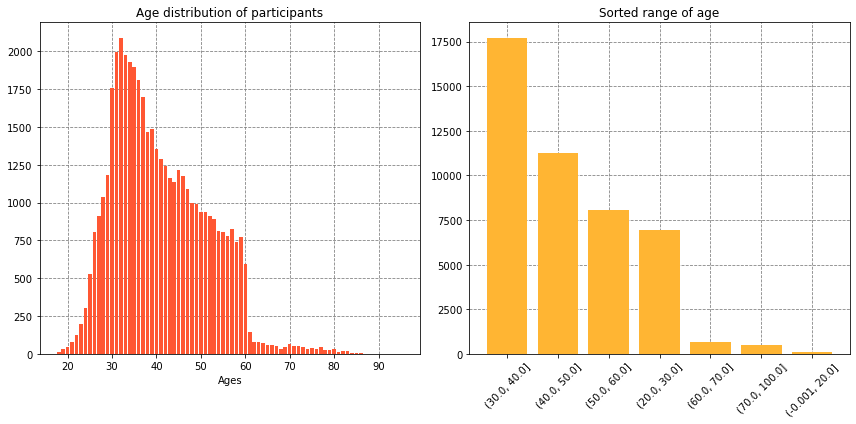

In [109]:
fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].bar(bank_train.age.value_counts().index, bank_train.age.value_counts(), color = '#FF5733')
axs[0].title.set_text('Age distribution of participants')
axs[0].set_xlabel('Ages')
axs[0].set_axisbelow(True)
axs[0].grid(color='gray', linestyle='dashed')

axs[1].bar(bank_train.age.value_counts(bins=[0,20,30,40,50,60,70,100]).index.astype('str'),
           bank_train.age.value_counts(bins=[0,20,30,40,50,60,70,100]), color = '#FFB533')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].title.set_text('Sorted range of age')
axs[1].set_axisbelow(True)
axs[1].grid(color='gray', linestyle='dashed')

plt.tight_layout()
plt.show()

## Pre-processing

In [120]:
object_col = bank_train.drop(numeric_col, axis=1)
object_col.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown,no
4,unknown,single,unknown,no,no,no,unknown,may,unknown,no


In [150]:
# Investigation of missing values
unknown_dict = {}
for i in object_col.columns:
    unknown_dict[i] = [(object_col[i] == 'unknown').sum()]

In [160]:
unknown_df = pd.DataFrame(unknown_dict, index=['countUnknown']).T

In [166]:
print(unknown_df.sort_values('countUnknown', axis=0, ascending=False))

           countUnknown
poutcome          36959
contact           13020
education          1857
job                 288
marital               0
default               0
housing               0
loan                  0
month                 0
y                     0


We have myriad unknown values within categorical columns, however it's nearly impossible to assign any value instead of these. So that, we will accept 'unknown' values as a category. 

### Mapping for Categorical Variables

In [175]:
object_col.head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown,no
4,unknown,single,unknown,no,no,no,unknown,may,unknown,no


In [9]:
# It will convert columns that have string dtypes to pandas category type
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype("category").cat.as_ordered()
            
# Mapping that we are using for training set must be equal to validation and test sets'
def apply_cats(df, train):
    for n, c in df.items():
        if train[n].dtype == "category":
            df[n] = pd.Categorical(c, categories = train[n].cat.categories, ordered = True)

In [232]:
df = bank_train.copy()

In [233]:
train_cats(df)

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        45211 non-null  int64   
 1   job        45211 non-null  category
 2   marital    45211 non-null  category
 3   education  45211 non-null  category
 4   default    45211 non-null  category
 5   balance    45211 non-null  int64   
 6   housing    45211 non-null  category
 7   loan       45211 non-null  category
 8   contact    45211 non-null  category
 9   day        45211 non-null  int64   
 10  month      45211 non-null  category
 11  duration   45211 non-null  int64   
 12  campaign   45211 non-null  int64   
 13  pdays      45211 non-null  int64   
 14  previous   45211 non-null  int64   
 15  poutcome   45211 non-null  category
 16  y          45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


In [178]:
df.marital

0         married
1          single
2         married
3         married
4          single
           ...   
45206     married
45207    divorced
45208     married
45209     married
45210     married
Name: marital, Length: 45211, dtype: category
Categories (3, object): ['divorced' < 'married' < 'single']

In [179]:
df.education

0         tertiary
1        secondary
2        secondary
3          unknown
4          unknown
           ...    
45206     tertiary
45207      primary
45208    secondary
45209    secondary
45210    secondary
Name: education, Length: 45211, dtype: category
Categories (4, object): ['primary' < 'secondary' < 'tertiary' < 'unknown']

In [220]:
df["education"].cat.set_categories(["unknown", "primary", "secondary", "tertiary"], ordered = True, inplace = True)

In [186]:
df.month

0        may
1        may
2        may
3        may
4        may
        ... 
45206    nov
45207    nov
45208    nov
45209    nov
45210    nov
Name: month, Length: 45211, dtype: category
Categories (12, object): ['apr' < 'aug' < 'dec' < 'feb' ... 'may' < 'nov' < 'oct' < 'sep']

In [221]:
df["month"].cat.set_categories(["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"],
                               ordered = True, inplace = True)

In [189]:
df.poutcome

0        unknown
1        unknown
2        unknown
3        unknown
4        unknown
          ...   
45206    unknown
45207    unknown
45208    success
45209    unknown
45210      other
Name: poutcome, Length: 45211, dtype: category
Categories (4, object): ['failure' < 'other' < 'success' < 'unknown']

We can assign "other" to unknown values since they unknown is included by other outcomes. It will be considered in the further steps.

In [222]:
df["poutcome"].cat.set_categories(["unknown", "failure", "other", "success"], ordered = True, inplace = True)

In [223]:
df["contact"].cat.set_categories(["unknown", "telephone", "cellular"], ordered = True, inplace = True)

In [211]:
df.job.cat.categories

Index(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
       'retired', 'self-employed', 'services', 'student', 'technician',
       'unemployed', 'unknown'],
      dtype='object')

Intuitional approach to job categories:

In [224]:
df["job"].cat.set_categories(["unknown", "unemployed", "student", "retired", "housemaid", "blue-collar",
                             "services", "technician", "entrepreneur", "self-employed", "management", "admin."], ordered = True, inplace = True)

In [213]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Except the unkown entries, we do not have any missing value to handle.

In [10]:
def numericalize(df, col, name):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes+1

In [11]:
for n, c in df.items():
    numericalize(df, c, n)

NameError: name 'df' is not defined

In [235]:
y = df.y.values
df.drop('y', axis = 1, inplace = True)

In [12]:
# All the settings that we made so far

def bank_test_format(df):
        
    train_cats(df)
    
    df["education"].cat.set_categories(["unknown", "primary", "secondary", "tertiary"], ordered = True, inplace = True)
    df["month"].cat.set_categories(["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"],
                               ordered = True, inplace = True)
    df["poutcome"].cat.set_categories(["unknown", "failure", "other", "success"], ordered = True, inplace = True)
    df["contact"].cat.set_categories(["unknown", "telephone", "cellular"], ordered = True, inplace = True)
    df["job"].cat.set_categories(["unknown", "unemployed", "student", "retired", "housemaid", "blue-collar",
                             "services", "technician", "entrepreneur", "self-employed", "management", "admin."], ordered = True, inplace = True)
    
    for n, c in df.items():
        numericalize(df, c, n)
    y = df.y.values
    df.drop('y', axis = 1, inplace = True)
    
    return df, y

## Random Forest

In [15]:
# Creating validation set

def split_train_val(df,n): 
    
    return df[:n].copy(), df[n:].copy()

In [242]:
n_valid = int(len(df) * (20/100))  # I'd take 20% of dataset as validation set.
n_train = len(df)-n_valid
X_train, X_valid = split_train_val(df, n_train)
y_train, y_valid = split_train_val(y, n_train)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((36169, 16), (36169,), (9042, 16), (9042,))

In [14]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    
    print(f"RMSE of train set {rmse(m.predict(X_train), y_train)}")
    print(f"RMSE of validation set {rmse(m.predict(X_valid), y_valid)}")
    print(f"R^2 of train set {m.score(X_train, y_train)}")
    print(f"R^2 of validation set {m.score(X_valid, y_valid)}")

In [277]:
reg = RandomForestRegressor(n_jobs=-1)
%time reg.fit(X_train, y_train)
print_score(reg)

CPU times: user 15.3 s, sys: 72 ms, total: 15.3 s
Wall time: 4.54 s
RMSE of train set 0.07580296295265992
RMSE of validation set 0.4579932039109071
R^2 of train set 0.9084180958302376
R^2 of validation set 0.02931357993245809


## After realising that it is not appropriate to take categorical y variable, I decided to use 'age' variable as my dependent variable.
Thanks to my 0.029 validation score..

In [13]:
df_2 = bank_train.copy()

In [16]:
df_2.rename(columns={'y': 'subscribed', 'age':'y'}, inplace = True)

In [17]:
df_2.head()

,y,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [18]:
df_2, y_2 = bank_test_format(df_2)

In [19]:
df_2.head()

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,11,2,4,1,2143,2,1,1,5,5,261,1,-1,0,1,1
1,8,3,3,1,29,2,1,1,5,5,151,1,-1,0,1,1
2,9,2,3,1,2,2,2,1,5,5,76,1,-1,0,1,1
3,6,2,1,1,1506,2,1,1,5,5,92,1,-1,0,1,1
4,1,3,1,1,1,1,1,1,5,5,198,1,-1,0,1,1


In [20]:
y_2

array([58, 44, 33, ..., 72, 57, 37])

In [21]:
n_valid = int(len(df_2) * (20/100))  # I'd take 20% of dataset as validation set.
n_train = len(df_2)-n_valid
X_train, X_valid = split_train_val(df_2, n_train)
y_train, y_valid = split_train_val(y_2, n_train)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((36169, 16), (36169,), (9042, 16), (9042,))

In [22]:
reg = RandomForestRegressor(n_jobs=-1)
%time reg.fit(X_train, y_train)
print_score(reg)

CPU times: user 21.8 s, sys: 234 ms, total: 22 s
Wall time: 6.16 s
RMSE of train set 2.9280261707868878
RMSE of validation set 9.698972718852218
R^2 of train set 0.9079678293959823
R^2 of validation set 0.5074190538622134


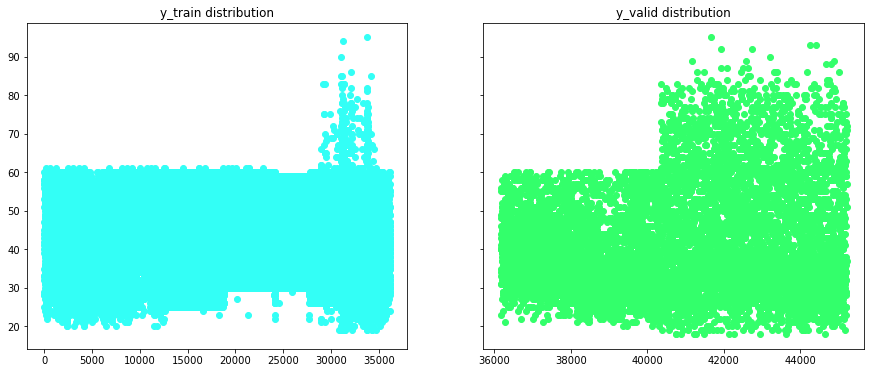

In [23]:
fig, axs = plt.subplots(1, 2, sharey = True, figsize = (15, 6))

axs[0].scatter(X_train.index, y_train, c = '#33FFF6')
axs[0].title.set_text('y_train distribution')

axs[1].scatter(X_valid.index, y_valid, c = '#33FF6B')
axs[1].title.set_text('y_valid distribution')

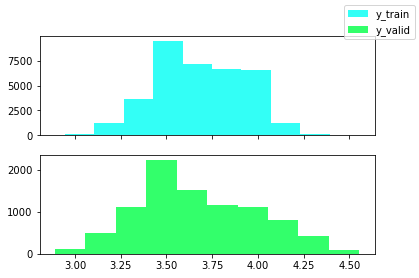

In [24]:
fig, axs = plt.subplots(2, sharex = True)

axs[0].hist(np.log(y_train), label='y_train', color='#33FFF6')
axs[1].hist(np.log(y_valid), label='y_valid', color='#33FF6B')

fig.legend(loc='upper right')



In [25]:
np.log(y_train)

array([4.06044301, 3.78418963, 3.49650756, ..., 3.80666249, 3.71357207,
       3.55534806])

Since we chase a validation set from the tail of dataframe, the age distribution have not been separeted fairly. Let's choose a different method to split the dataframe into train & validation

In [26]:
random_index = np.random.randint(0,len(df_2),n_valid)

In [27]:
X_train, X_valid = df_2.drop(random_index, axis=0), df_2.iloc[random_index,:]
y_train, y_valid = np.delete(y_2, random_index), y_2[random_index]

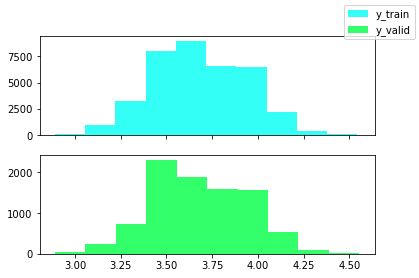

In [28]:
fig, axs = plt.subplots(2, sharex = True)

axs[0].hist(np.log(y_train), label='y_train', color='#33FFF6')
axs[1].hist(np.log(y_valid), label='y_valid', color='#33FF6B')

fig.legend(loc='upper right')

### Trying again...

In [29]:
reg = RandomForestRegressor(n_jobs=-1)
reg.fit(X_train, y_train)
print_score(reg)

RMSE of train set 2.967791845912418
RMSE of validation set 8.045128917064785
R^2 of train set 0.9217475744731579
R^2 of validation set 0.4280396351712742


Seems like an overfitting occured

## Different Approachs

In [31]:
def get_sample(df,n):

    idxs = np.random.permutation(len(df))[:n]
    return idxs, df.iloc[idxs].copy()

In [32]:
# Creating subset
idxs, X_train = get_sample(X_train, 3000)

y_train = y_train[idxs]

In [33]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE of train set 3.1069291108745944
RMSE of validation set 8.378388039619933
R^2 of train set 0.9122378455955552
R^2 of validation set 0.3796727489894929


### Single Tree

In [34]:
from sklearn import tree
import matplotlib.pyplot as plt

In [35]:
m = RandomForestRegressor(n_estimators=1, max_depth=4, bootstrap=False, n_jobs=-1)
t = m.fit(X_train, y_train)
print_score(m)

RMSE of train set 8.236019548492417
RMSE of validation set 8.425825525009204
R^2 of train set 0.3832923655296211
R^2 of validation set 0.3726284177233764


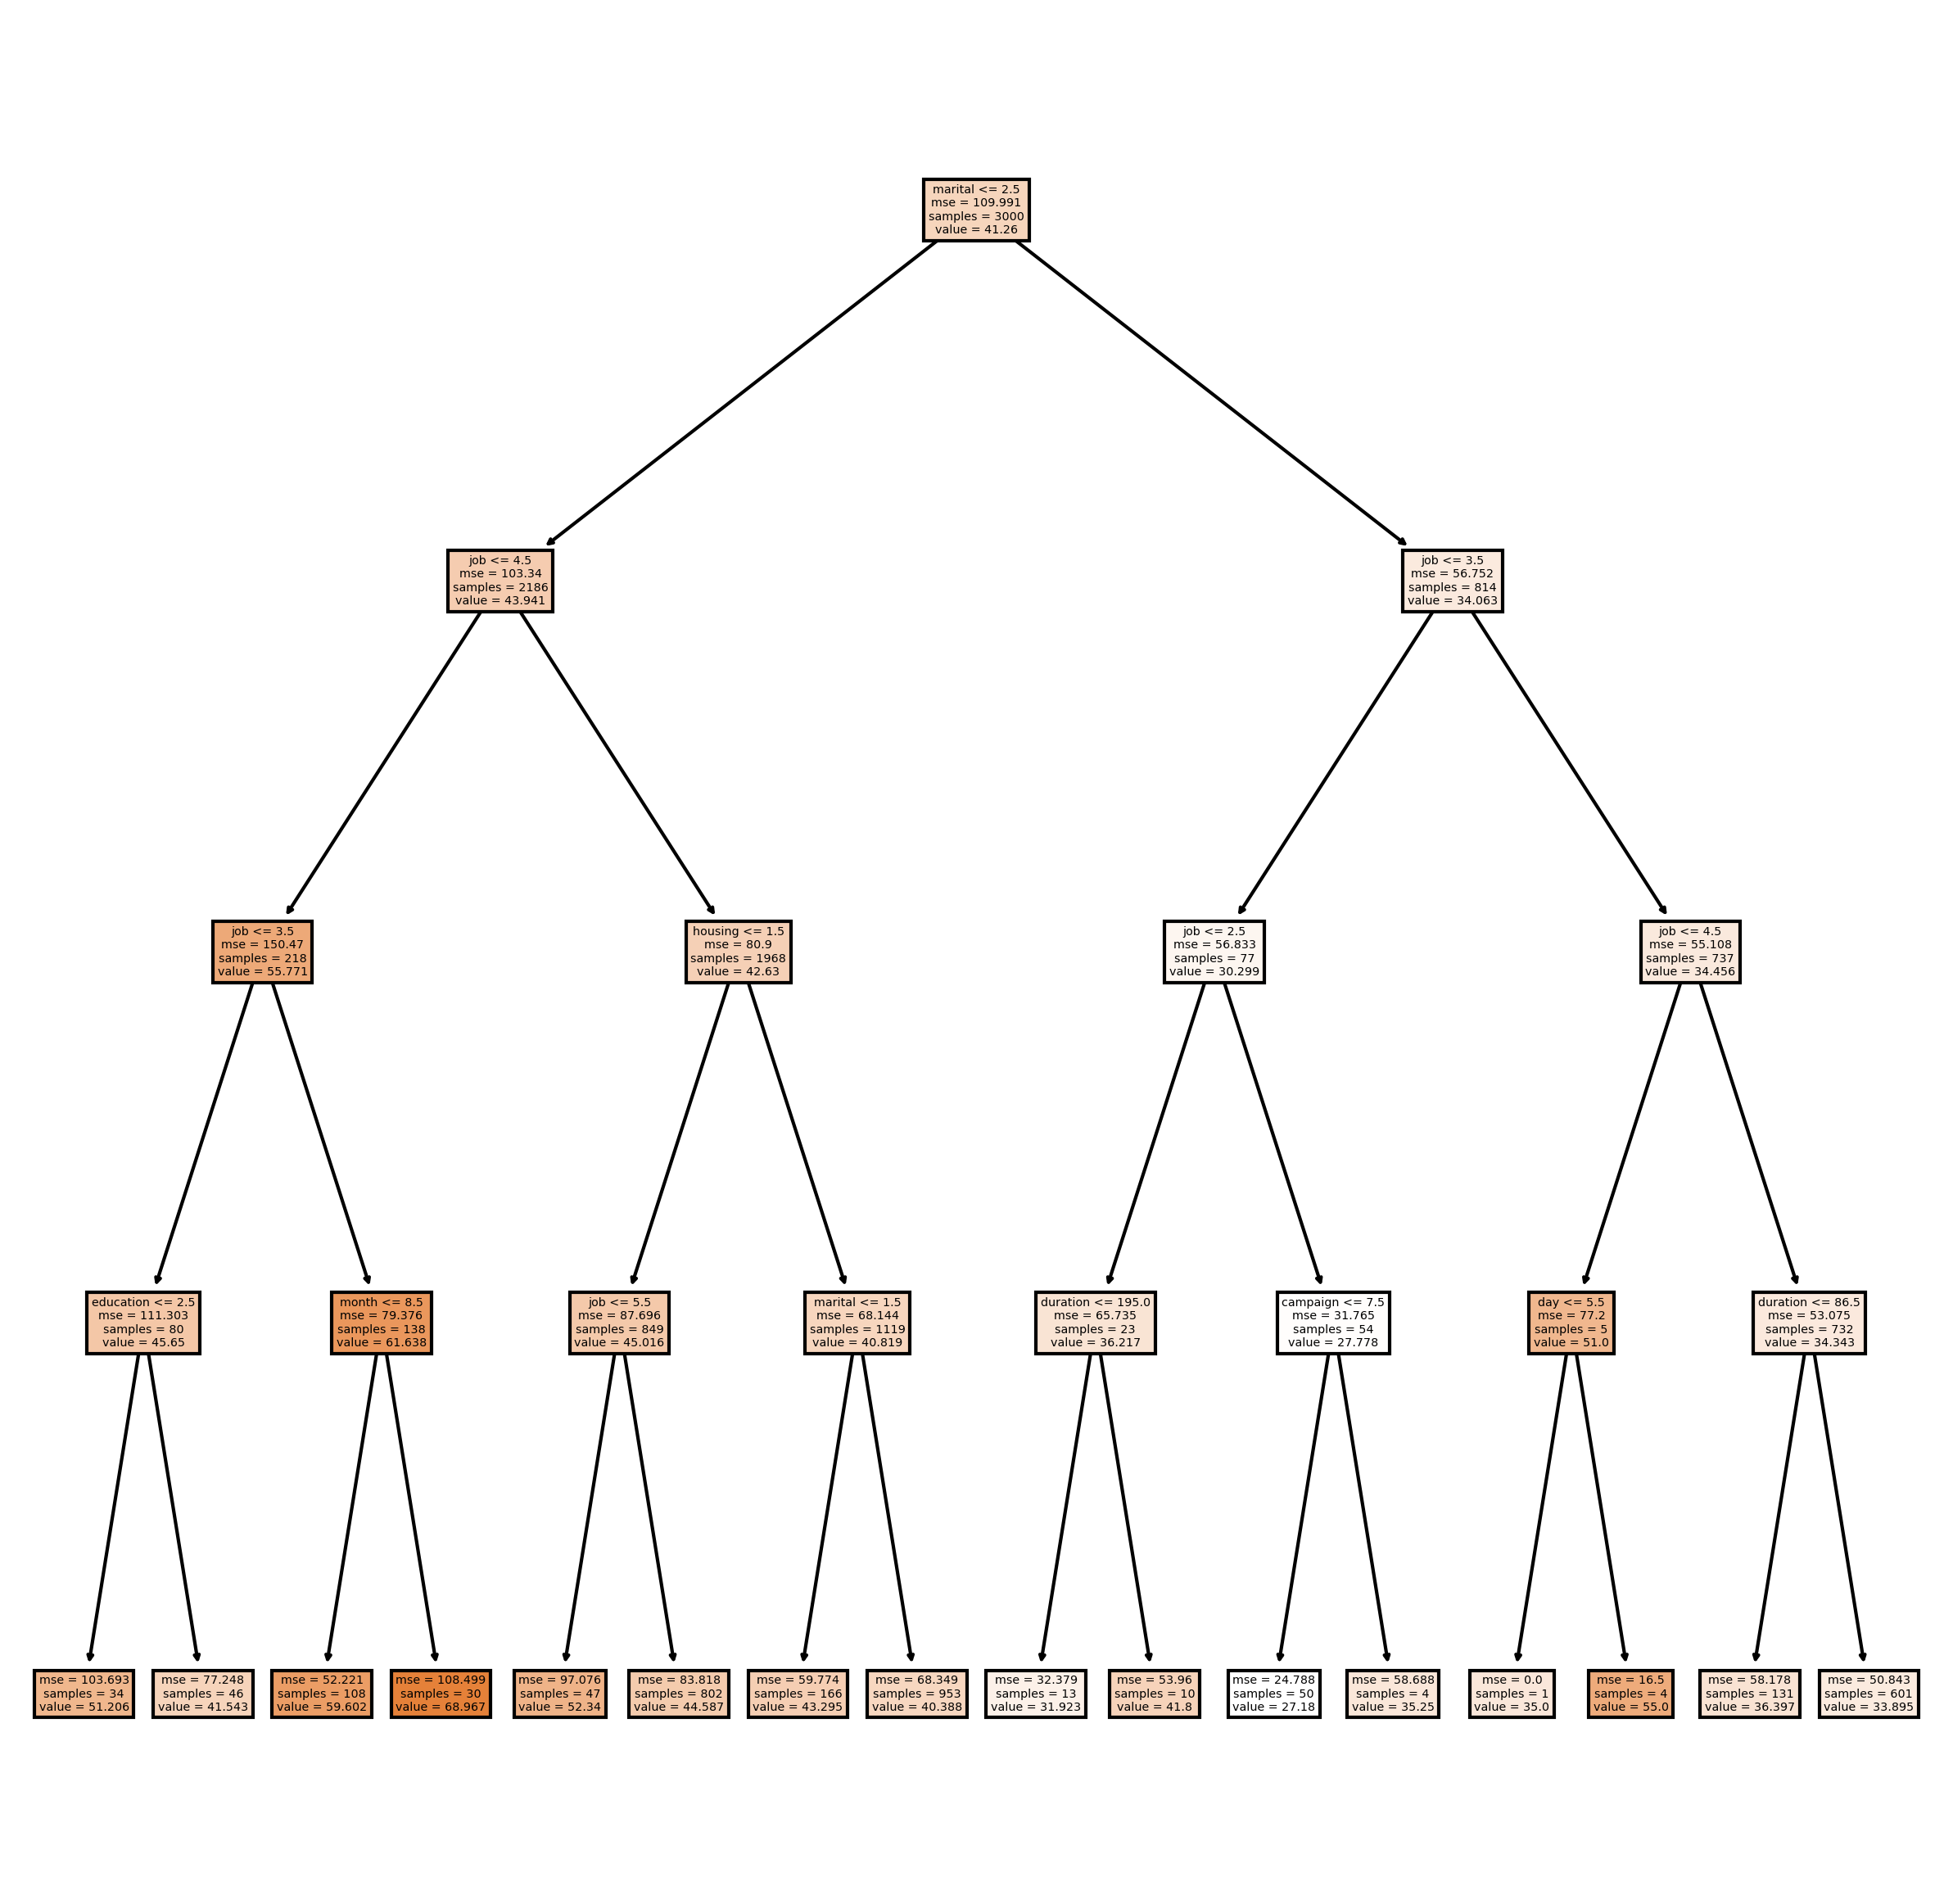

In [36]:
estimator = m.estimators_[0]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(estimator, feature_names=df_2.columns,filled=True);

In [39]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1) # Overfitting
m.fit(X_train, y_train)
print_score(m) 

RMSE of train set 0.0
RMSE of validation set 11.496193459429284
R^2 of train set 1.0
R^2 of validation set -0.16790642102623154


In [482]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)

preds = np.array([t.predict(X_valid) for t in m.estimators_])
print(preds[:,0]) 
print('Estimated y0 from valid: ', np.mean(preds[:,0]))
print('Actual y0 from valid: ', y_valid[0])

[32. 50. 36. 49. 46. 56. 42. 39. 30. 34. 41. 49. 42. 38. 36. 48. 32. 32.
 37. 49. 32. 42. 33. 30. 36. 37. 37. 36. 40. 41. 32. 49. 36. 29. 42. 36.
 32. 37. 57. 29. 56. 38. 34. 34. 37. 42. 59. 41. 53. 34. 40. 36. 39. 42.
 35. 36. 27. 32. 31. 50. 36. 37. 32. 36. 51. 32. 32. 32. 56. 42. 38. 57.
 42. 41. 36. 36. 28. 37. 40. 37. 41. 52. 48. 36. 36. 42. 32. 41. 32. 36.
 59. 36. 36. 40. 42. 41. 41. 50. 31. 54.]
Estimated y0 from valid:  39.61
Actual y0 from valid:  45


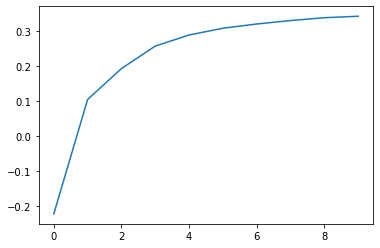

In [474]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

In [479]:
%%time

m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE of train set 3.3640713181104434
RMSE of validation set 8.389378056702364
R^2 of train set 0.898292621521202
R^2 of validation set 0.369909133515981
CPU times: user 517 ms, sys: 21.1 ms, total: 538 ms
Wall time: 263 ms


In [480]:
%%time

m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE of train set 3.165836152056304
RMSE of validation set 8.270199941677058
R^2 of train set 0.9099261055567868
R^2 of validation set 0.38768391052614837
CPU times: user 979 ms, sys: 31.6 ms, total: 1.01 s
Wall time: 387 ms


In [481]:
%%time

m = RandomForestRegressor(n_estimators=120, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

RMSE of train set 3.0550725047466973
RMSE of validation set 8.202502057303091
R^2 of train set 0.9161187072131548
R^2 of validation set 0.3976674282068505
CPU times: user 2.59 s, sys: 65 ms, total: 2.65 s
Wall time: 888 ms


### OOB Score

In [483]:
def print_score(m):
    
    print(f"RMSE of train set {rmse(m.predict(X_train), y_train)}")
    print(f"RMSE of validation set {rmse(m.predict(X_valid), y_valid)}")
    print(f"R^2 of train set {m.score(X_train, y_train)}")
    print(f"R^2 of validation set {m.score(X_valid, y_valid)}")
    if hasattr(m, "oob_score_"):
        print(f"OOB score: {m.oob_score_}")

In [484]:
m = RandomForestRegressor(n_estimators=50, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE of train set 3.1543650813858983
RMSE of validation set 8.268184281428221
R^2 of train set 0.9105776693360095
R^2 of validation set 0.3879823484851497
OOB score: 0.3586849637299031


In [485]:
%prun m.fit(X_train, y_train)

In [502]:
m = RandomForestRegressor(n_estimators=35, min_samples_leaf=4, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

RMSE of train set 5.704805853275897
RMSE of validation set 8.16823995475151
R^2 of train set 0.7075148574147408
R^2 of validation set 0.40268884219335943
OOB score: 0.3858642757785904


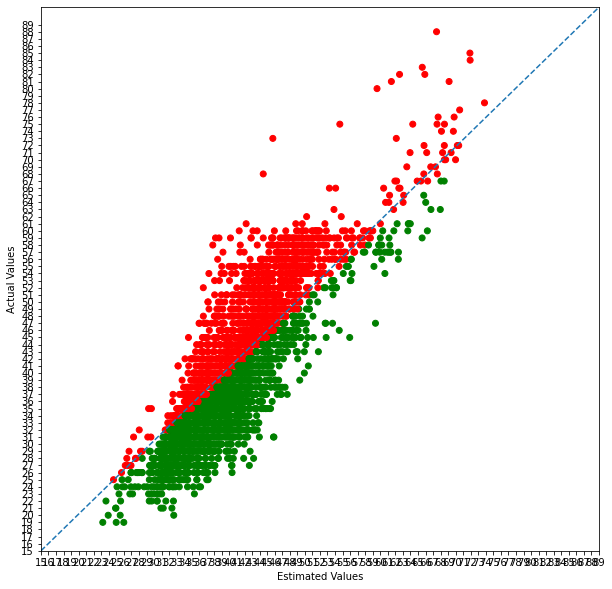

In [577]:
f, ax = plt.subplots(figsize=(10, 10))

col = np.where(h<y_train, 'r', np.where(y_train<h, 'g', 'yellow'))
ax.scatter(h, y_train, c=col)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed')
labels = np.arange(15,90,1)
plt.xticks(labels)
plt.yticks(labels)

ax.set_xlabel('Estimated Values')
ax.set_ylabel('Actual Values')
plt.show()

